In [464]:
import pandas as pd
import numpy as np
from my.data.basic_func import get_basic_data
from my.data.meta_api import get_before_trade_info
from finance_ml.labeling import get_barrier_labels
import multiprocessing as mp
from sklearn.model_selection import train_test_split
from datetime import datetime
import lightgbm as lgb
import factors
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from scipy import signal

In [2]:
start_dt = 20230103
end_dt = 20230214

table_name = "bond_calendar"
df = get_basic_data(20230728, table_name)
cal_list = df[df.exchmarket == "NIB"].trade_dt
dates = []
for i in cal_list:
    if (int(i) >= start_dt) & (int(i) <= end_dt):
        dates.append(int(i))
dates_not_in = [20221219,20221231, 20230120, 20230128, 20230129, 20230215,20230216, 20230423, 20230506, 20230625]
# dates_not_in = [20221219,20221231, 20230120, 20230129, 20230423, 20230506, 20230625]
for j in dates_not_in:
    if j in dates:
        dates.remove(j)

In [3]:
def stamp2dt(timestamp):
    if len(str(timestamp)) > 10:
        timestamp = timestamp / pow(10, (len(str(timestamp)) - 10))

    dt = datetime.fromtimestamp(timestamp)
    return dt

In [4]:
Fx = []
Fy = []
for date in dates:
    df_mc = get_before_trade_info(date, "bond_main_contract")
    mc_dict = dict(zip(df_mc.label, df_mc.securityid))
    if "CDB10Y01.IB" in mc_dict:
        bond_code = mc_dict["CDB10Y01.IB"]
    else:
        bond_code = '220220.IB'
    terms, y = factors.get_factors(bond_code, date)

    print(date)
    terms = np.array(terms)
    Fx.append(terms)  # label drops last minute
    Fy.append(y)

20230103
20230104
20230105
20230106
20230109
20230110
20230111
20230112
20230113
20230116
20230117
20230118
20230119
20230130
20230131
20230201
20230202
20230203
20230206
20230207
20230208
20230209
20230210
20230213
20230214


In [5]:
# resample 900 ticks
# ticks = 900
# Fy_resam = np.array((len(Fy), ticks))
# Fx_resam = np.array((len(Fy), len(Fx[0]), ticks ))
# for i in range(len(Fy)):
#     Fy_resam[i,:] = signal.resample(Fy[i], ticks)
Fx_resam = []
Fy_resam = []
for i in range(len(Fx)):
    Fx_resam.append(Fx[i][:,::5])
    Fy_resam.append(Fy[i][::5])

In [364]:
# simply cut 25 days in 5 periods 
model_label = ['1st5d','2nd5d']
test1: train : 1-200 test 201 
test2: train:  2-201 test 202
test3: train:  3-203 test 203
test4: 4 实盘 


# test: 1-5 test 6
# test: 1-10 test 

Fx_total=[Fx_resam[:5], 
          
          Fx_resam[5:10], Fx_resam[10:15], Fx_resam[15:20], Fx_resam[20:]]
Fy_total = [Fy_resam[:5], Fy_resam[5:10], Fy_resam[10:15], Fy_resam[15:20], Fy_resam[20:]]

In [ ]:
# features selection
gridsearch 选择超参
best estimater feature_importance ranking top 50 in 100 
1. 找因子 
2. 找到参数 一天一次
train 1-5 天


In [369]:
def lightgbmTest():
    import lightgbm as lgb
    # 第一步，初始化模型为None，设置模型参数
    gbm = None
    params = {
        'task': 'train',
        'application': 'regression',  # 目标函数
        'boosting_type': 'gbdt',  # 设置提升类型
        'learning_rate': 0.01,  # 学习速率
        'num_leaves': 50,  # 叶子节点数
        'tree_learner': 'serial',
        'min_data_in_leaf': 100,
        'metric': ['l1', 'l2', 'rmse'],  # l1:mae, l2:mse  # 评估函数
        'max_bin': 255,
        'num_trees': 300
    } 
    for i in range(5):
        # 创建lgb的数据集
        # y_ = list(map(float, y_))  # 将numpy.ndarray转变为list
        X_ = Fx_total[i]
        y_ = Fy_total[i]
 
        X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.25, random_state=0)
        # y_train = y_train.ravel()
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
 
        # 第三步：增量训练模型
        # 通过 init_model 和 keep_training_booster 两个参数实现增量训练
        gbm = lgb.train(params,
                        lgb_train,
                        num_boost_round=1000,
                        valid_sets=lgb_eval,
                        init_model=gbm,  # 如果gbm不为None，那么就是在上次的基础上接着训练
                        # feature_name=x_cols,
                        early_stopping_rounds=10,
                        verbose_eval=False,
                        keep_training_booster=True)  # 增量训练
 
        print("{} time".format(i))  # 当前次数
        # 输出模型评估分数
        score_train = dict([(s[1], s[2]) for s in gbm.eval_train()])
        print('当前模型在训练集的得分是：mae=%.4f, mse=%.4f, rmse=%.4f'
              % (score_train['l1'], score_train['l2'], score_train['rmse']))
 
    return gbm

In [463]:
i=0
# 创建lgb的数据集
# y_ = list(map(float, y_))  # 将numpy.ndarray转变为list
X_ = Fx_total[i]
y_ = Fy_total[i]

params = {
    'task': 'train',
    'application': 'regression',  # 目标函数
    'boosting_type': 'gbdt',  # 设置提升类型
    'learning_rate': 0.01,  # 学习速率
    'num_leaves': 50,  # 叶子节点数
    'tree_learner': 'serial',
    'min_data_in_leaf': 100,
    'metric': ['l1', 'l2', 'rmse'],  # l1:mae, l2:mse  # 评估函数
    'max_bin': 255,
    'num_trees': 300
}

X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.25, random_state=0)
# y_train = y_train.ravel()
lgb_train = lgb.Dataset(X_train[0].transpose(), y_train[0])
lgb_eval = lgb.Dataset(X_test[0], y_test[0], reference=lgb_train)
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,
                init_model=None,  # 如果gbm不为None，那么就是在上次的基础上接着训练
                # feature_name=x_cols,
                early_stopping_rounds=10,
                verbose_eval=False,
                keep_training_booster=True)  # 增量训练


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1466
[LightGBM] [Info] Number of data points in the train set: 1690, number of used features: 9


LightGBMError: Length of label is not same with #data

In [385]:
np.shape(y_train[0])

(1690,)

In [386]:
X_train[0].transpose().shape

(1690, 9)

In [ ]:
'''lightgbm增量训练'''
print('lightgbm增量训练')
train_X, test_X, train_y, test_y = train_test_split(Fx_resam, Fy_resam, test_size=0.25)
# lgb_train = lgb.Dataset(train_X, train_y)
# lgb_test  = lgb.Dataset(test_X, test_y)
# train_X, test_X, train_Y, test_Y = train_test_split(train_data, train_label, test_size=0.1, random_state=0)
# train_X, train_Y = shuffle(train_data, train_label, random_state=0)  # random_state=0用于记录打乱位置 保证每次打乱位置不变

gbm = lightgbmTest()
pred_Y = gbm.predict(test_X)
# print('compute_loss:{}'.format(compute_loss(test_Y, pred_Y)))

# gbm.save_model('lightgbmtest.model')
# 模型存储
# joblib.dump(gbm, 'loan_model.pkl')
# # 模型加载
# gbm = joblib.load('loan_model.pkl')

In [456]:
lgb_train = lgb.Dataset(X_train[0].transpose(), y_train[0])
lgb_eval = lgb.Dataset(X_test[0], y_test[0], reference=lgb_train)
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,
                init_model=None,  # 如果gbm不为None，那么就是在上次的基础上接着训练
                # feature_name=x_cols,
                early_stopping_rounds=10,
                verbose_eval=False,
                keep_training_booster=True)  # 增量训练

22

In [13]:
200day * factors * ticks

np.hstack
2
3

(9, 2196)

In [ ]:
9:30 - 16:30  300
9:30 -   300
 300

行数 = 200 * 300 = 60000

train_x = 60000 * 9   train_y: 60000
1 - 300
1 - 300
60-120 10:11am


实盘： 

In [11]:
# 调用LightGBM模型，使用训练集数据进行训练（拟合）
# Add verbosity=2 to print messages while running boosting
train_X, test_X, train_y, test_y = train_test_split(Fx_resam, Fy_resam, test_size=0.1)
lgb_train = lgb.Dataset(train_X, train_y)
lgb_test  = lgb.Dataset(test_X, test_y)
my_model = lgb.LGBMRegressor(objective="regression", num_leaves=10, learning_rate=0.1, n_estimators=20, verbosity=2)
my_model.fit(np.array(train_X[0:5]).transpose(), train_y[0:5], verbose=False)
# my_model.fit(train_X[1].transpose(), train_y[1], verbose=False)

ValueError: could not broadcast input array from shape (9,2196) into shape (9,)

In [7]:
predictions = my_model.predict(test_X[0].transpose())

# 对模型的预测结果进行评判（平均绝对误差）
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y[0])))

Mean Absolute Error : 0.5161843639763346


In [25]:
test_y[0]

array([97.54245 , 97.540405, 97.532196, ..., 97.50835 , 97.50755 ,
       97.5075  ], dtype=float32)

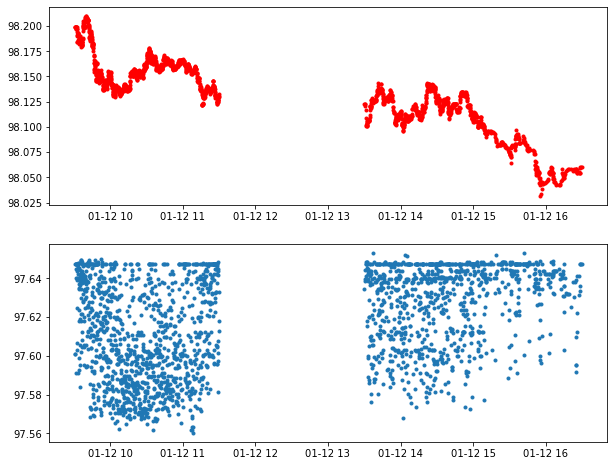

In [8]:
fig, ax = plt.subplots(2,1, figsize=(10,8))
ax[0].plot(test_y[0],'.',color='r')
ax[1].plot(test_y[0].index, predictions,'.')
# fig.savefig('regression.jpg', dpi = 300)

In [ ]:
def lightgbmTest():
    import lightgbm as lgb
    # 第一步，初始化模型为None，设置模型参数
    gbm = None
    params = {
        'task': 'train',
        'application': 'regression',  # 目标函数
        'boosting_type': 'gbdt',  # 设置提升类型
        'learning_rate': 0.01,  # 学习速率
        'num_leaves': 50,  # 叶子节点数
        'tree_learner': 'serial',
        'min_data_in_leaf': 100,
        'metric': ['l1', 'l2', 'rmse'],  # l1:mae, l2:mse  # 评估函数
        'max_bin': 255,
        'num_trees': 300
    }
 
    # # 第二步，流式读取数据(每次10万)
    # minibatch_train_iterators = iter_minibatches(minibatch_size=10000)
    for 
 
    for i, (X_, y_) in enumerate(minibatch_train_iterators):
        # 创建lgb的数据集
        # y_ = list(map(float, y_))  # 将numpy.ndarray转变为list
 
        X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.1, random_state=0)
        y_train = y_train.ravel()
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
 
        # 第三步：增量训练模型
        # 重点来了，通过 init_model 和 keep_training_booster 两个参数实现增量训练
        gbm = lgb.train(params,
                        lgb_train,
                        num_boost_round=1000,
                        valid_sets=lgb_eval,
                        init_model=gbm,  # 如果gbm不为None，那么就是在上次的基础上接着训练
                        # feature_name=x_cols,
                        early_stopping_rounds=10,
                        verbose_eval=False,
                        keep_training_booster=True)  # 增量训练
 
        print("{} time".format(i))  # 当前次数
        # 输出模型评估分数
        score_train = dict([(s[1], s[2]) for s in gbm.eval_train()])
        print('当前模型在训练集的得分是：mae=%.4f, mse=%.4f, rmse=%.4f'
              % (score_train['l1'], score_train['l2'], score_train['rmse']))
 
    return gbm

Text(0, 0.5, 'Label resample')

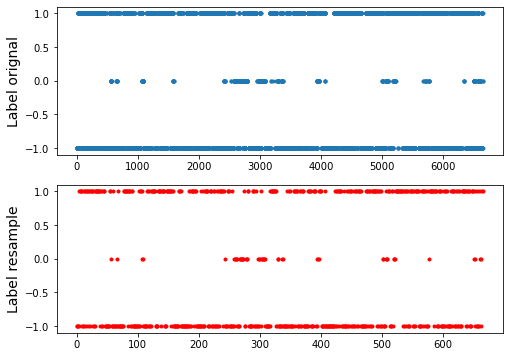

In [322]:
fig, ax = plt.subplots(2,1,figsize=(8,6))
ax[0].plot(Fy[0],'.')
ax[0].set_ylabel('Label orignal', fontsize=14)
ax[1].plot(Fy_resam[0],'.', color='r')
ax[1].set_ylabel('Label resample', fontsize=14)